# Project Goals

- Distribution of conservation status for species
- Is there an association between the different species and their conservation status?
- Animal that is least found and which Parks should we target to preserve them

# Import Python Modules

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load Data

In [197]:
species_info = pd.read_csv('species_info.csv', encoding = 'utf-8')
observations = pd.read_csv('observations.csv', encoding = 'utf-8')
# We combine both datasets together since they have a common column 'scientific_name'
full_data = pd.merge(species_info,observations)
full_data.head(10)

,category,scientific_name,common_names,conservation_status,park_name,observations
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Bryce National Park,130
1,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Yellowstone National Park,270
2,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Great Smoky Mountains National Park,98
3,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN,Yosemite National Park,117
4,Mammal,Bos bison,"American Bison, Bison",NaN,Yosemite National Park,128
5,Mammal,Bos bison,"American Bison, Bison",NaN,Yellowstone National Park,269
6,Mammal,Bos bison,"American Bison, Bison",NaN,Bryce National Park,68
7,Mammal,Bos bison,"American Bison, Bison",NaN,Great Smoky Mountains National Park,77
8,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN,Bryce National Park,99
9,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN,Yosemite National Park,124


# Problem 1: Conservation status distribution for Species

In [198]:
full_data.fillna('Stable', inplace = True)
full_data.groupby('conservation_status').size()

conservation_status
Endangered               80
In Recovery              24
Species of Concern      732
Stable                24752
Threatened               44
dtype: int64

In [199]:
conservation_by_category = full_data[full_data.conservation_status != "Stable"]\
.groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

conservation_by_category

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,4.0,16.0,12.0,44.0,NaN,NaN,4.0
In Recovery,NaN,12.0,NaN,12.0,NaN,NaN,NaN
Species of Concern,16.0,320.0,16.0,168.0,20.0,20.0,172.0
Threatened,8.0,NaN,20.0,8.0,NaN,NaN,8.0


Text(0, 0.5, 'Number of Species')

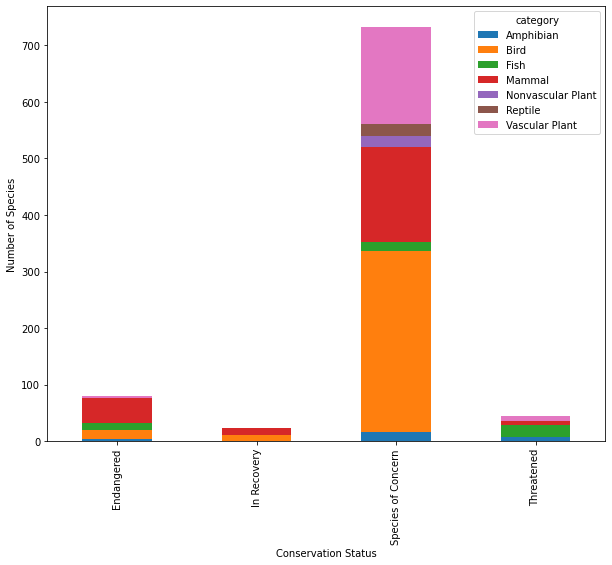

In [200]:
ax = conservation_by_category.plot(kind = 'bar', figsize = (10,8), stacked = True)
ax.set_xlabel('Conservation Status')
ax.set_ylabel('Number of Species')

# Problem 1 Conclusion

Vascular Plants, Mammals and Birds are the species' that are of most concern with regards to their conservation status

# Problem 2: Is there an association between the different species and their conservation status?

In [213]:
full_data['is_stable'] = full_data.conservation_status == 'Stable'
category_stable_count = full_data.groupby(['category','is_stable']).scientific_name.nunique()\
                    .reset_index()\
                    .pivot(columns = 'is_stable', index = 'category', values = 'scientific_name')\
                    .reset_index()
category_stable_count.columns = ['category','is_not_stable','is_stable']
category_stable_count['percent_stable'] = category_stable_count.is_not_stable / \
                                        (category_stable_count.is_not_stable + \
                                         category_stable_count.is_stable) * 100
category_stable_count
# From here, we see that the species in endangerment, relative to their total, are Mammals and Birds
# So let's focus on those 2

,category,is_not_stable,is_stable,percent_stable
0,Amphibian,7,72,8.860759
1,Bird,75,413,15.368852
2,Fish,11,115,8.730159
3,Mammal,30,146,17.045455
4,Nonvascular Plant,5,328,1.501502
5,Reptile,5,73,6.410256
6,Vascular Plant,46,4216,1.079305


In [217]:
cont1 = [[30,146],[75,413]]
chi2, pval, dof, expected = chi2_contingency(cont1)
print(chi2,pval,expected)
# chi2 value is lower than 4, hence there is no association
# p value is much larger than the standard 0.05, thus no association
# We can see that the expected values do not differ much from the original, thus no association

0.1617014831654557 0.6875948096661336 [[ 27.8313253 148.1686747]
 [ 77.1686747 410.8313253]]


In [219]:
# Let's see if there is an association between Bird and Vascular Plant
cont2 = [[75,413],[46,4216]]
chi2, pval, dof, expected = chi2_contingency(cont2)
print(chi2,pval,expected)
# chi2 value is much larger than 4, suggesting a strong association
# p value is much smaller than 0.05, suggesting a strong association
# We can see that the expected values differ much from original, suggesting a strong association

354.42332680820607 4.612268031690143e-79 [[  12.43115789  475.56884211]
 [ 108.56884211 4153.43115789]]


# Problem Conclusion 2

From this, we can see that certain species' conservation status can be associated with another species. We can think of this in reality as the food chain, where the dwindling of on species can have an effect on another

# Problem 3: Animal that is least found and which Parks should we preserve first

In [202]:
full_data['conservation_status'].unique()
# These is ordinal data whereby we rank the endangerment status of each species
species_of_concern = full_data[full_data['conservation_status'] == 'Species of Concern']
endangered = full_data[full_data['conservation_status'] == 'Endangered']
in_recovery = full_data[full_data['conservation_status'] == 'In Recovery']
threatened = full_data[full_data['conservation_status'] == 'Threatened']
species_of_concern_observ = species_of_concern.observations.mean()
endangered_observ = endangered.observations.mean()
in_recovery_observ = in_recovery.observations.mean()
threatened_observ = threatened.observations.mean()
# After observing the mean of observations, we find this ranking of endangerment
# 'Endangered' > 'Threatened' > 'In Recovery' > 'Species of Concern'

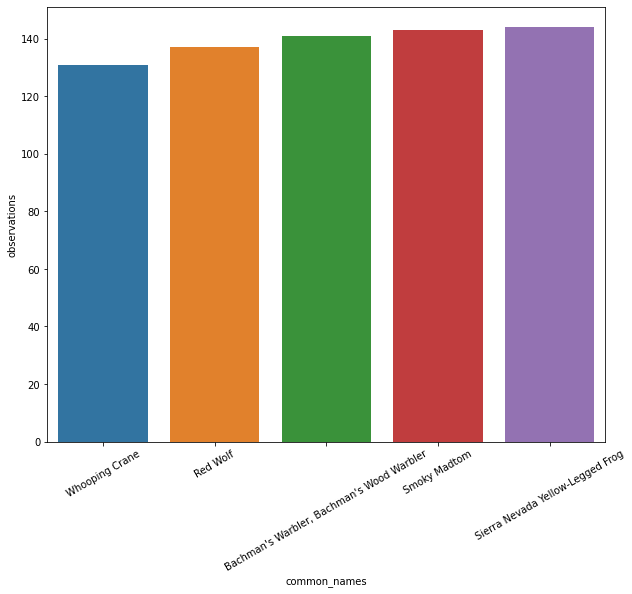

In [203]:
endangered_species = endangered.groupby('common_names').observations.sum().sort_values().reset_index()
endangered_species5 = endangered_species[:5]
# We gather the top 5 most endangered species, note that this is a Series
endangered_species5_observations = [i for i in endangered_species5['observations']]
endangered_species5_common_name = [i for i in endangered_species5['common_names']]
plt.figure(figsize=(10,8))
ax = plt.subplot()
ax.set_xticks(range(len(endangered_species5_common_name)))
ax.set_xticklabels(endangered_species5_common_name,rotation = 30)
sns.barplot(x = 'common_names', y = 'observations', data = endangered_species5)

plt.show()
# With this, we know that Rana sierrae is the top most endangered species, followed by Noturus baileyi and so on
# Now that we know the endangered species, we want to know which National Parks we need to focus on

In [204]:
yellow_legged_frog = full_data[full_data.common_names == 'Sierra Nevada Yellow-Legged Frog']
yellow_legged_frog = yellow_legged_frog.sort_values('observations')
yellow_legged_frog

,category,scientific_name,common_names,conservation_status,park_name,observations,is_stable
21015,Amphibian,Rana sierrae,Sierra Nevada Yellow-Legged Frog,Endangered,Great Smoky Mountains National Park,11,False
21014,Amphibian,Rana sierrae,Sierra Nevada Yellow-Legged Frog,Endangered,Bryce National Park,31,False
21012,Amphibian,Rana sierrae,Sierra Nevada Yellow-Legged Frog,Endangered,Yosemite National Park,42,False
21013,Amphibian,Rana sierrae,Sierra Nevada Yellow-Legged Frog,Endangered,Yellowstone National Park,60,False


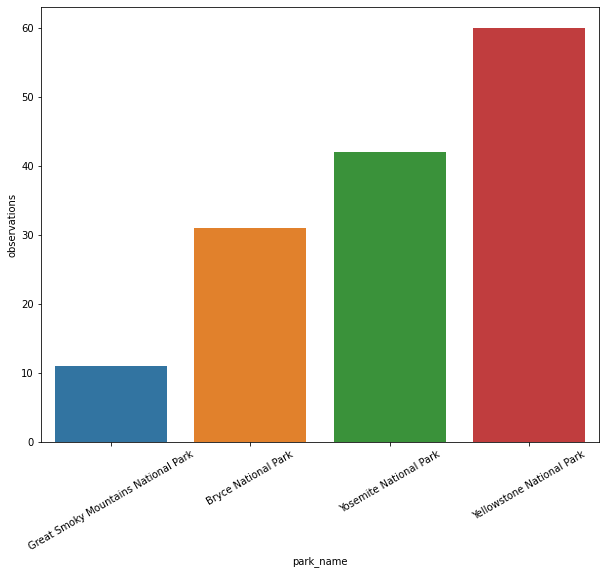

<Figure size 432x288 with 0 Axes>

In [205]:
plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.barplot(x = 'park_name', y = 'observations', data = yellow_legged_frog)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(yellow_legged_frog.park_name, rotation = 30)
plt.show()
plt.clf()

# Problem 3 Conclusion

We know that the most endangered animal is the Sierra Nevada Yellow-Legged Frog. We have to start preservation actions with Great Smoky Mountains National Park first, followed by Brcye National Park, Yosemite National Park and then Yellowstone National Park